# Inference demo

## Setup

In [ ]:
%cd '/workspace/pytorch/MPA/'
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)


In [ ]:
import math
import io
import torch
from torchvision import transforms as T
import numpy as np

from PIL import Image

import matplotlib
import matplotlib.pyplot as plt

from pytorch_msssim import ms_ssim

from compressai.models import MPA
from compressai.zoo import load_state_dict

from ipywidgets import interact, widgets

# my_font = font_manager.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/.ttf')
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Arial_Bold'
font = {'family': 'serif', 'weight': 'normal', 'size': 12}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42 # 42 force to use Type 1 font (defaults to 3, i.e. Type 3 font)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint_path = './checkpoints/pub/checkpoint_step3.pth.tar'

try:
    state_dict = load_state_dict(torch.load(checkpoint_path)['state_dict'])
except KeyError:
    state_dict = load_state_dict(torch.load(checkpoint_path))
# for key in state_dict.keys():
#     print(key, state_dict[key].size(0))
net = MPA.from_state_dict(state_dict).eval()
net = net.to(device)
net.update(force=True)

print(f'Parameters: {sum(p.numel() for p in net.parameters())}')


Parameters: 32124579


## Load image

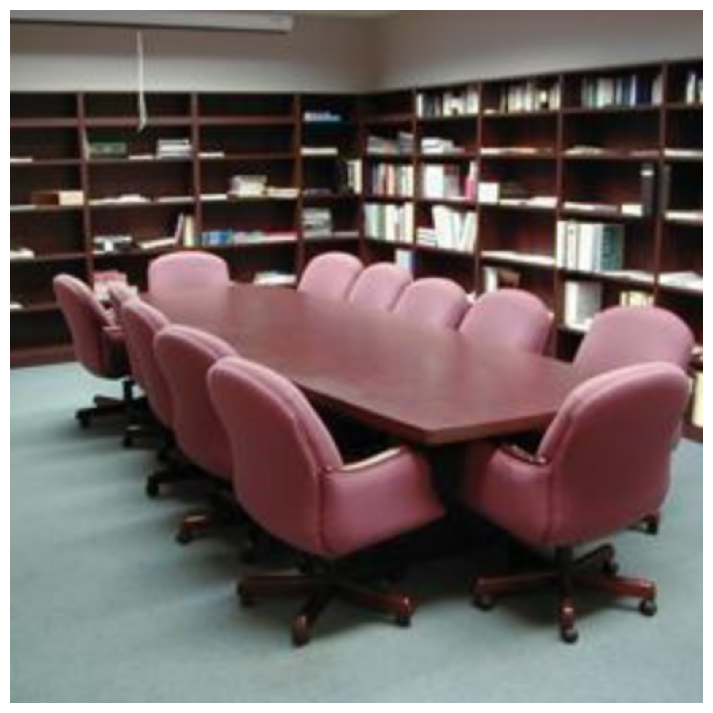

In [ ]:
ade20k_val_idx = '00000269'
# ade20k_val_idx = '00001200'
# ade20k_val_idx = '00001969'
img_path = f'./notebooks/assets/ADE_val_{ade20k_val_idx}.png'

img = Image.open(img_path).convert('RGB')
x = T.ToTensor()(img).unsqueeze(0).to(device)

%matplotlib inline
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img)
plt.show()


## Inference

In [22]:
from seg_util import dataset, transform
from seg_util.util import intersectionAndUnionGPU
from seg_model.pspnet import PSPNet
acc_criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
seg_model = PSPNet(layers=50, classes=150, zoom_factor=8, criterion=acc_criterion, pretrained=False)
seg_model.to(device)
seg_checkpoint = torch.load('./checkpoints/pspnet/pspnet_train_epoch_100.pth')['state_dict']
seg_checkpoint = {k.replace('module.', ''): v for k, v in seg_checkpoint.items()}
seg_model.load_state_dict(seg_checkpoint)
seg_model.eval()

PSPNet(
  (criterion): CrossEntropyLoss()
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Co

In [5]:
def cal_psnr(a: torch.Tensor, b: torch.Tensor) -> float:
    psnr = []
    for i in range(len(a)):
        mse = torch.nn.functional.mse_loss(a[i], b[i]).item()
        psnr.append(-10 * math.log10(mse))
    return sum(psnr) / len(psnr)


Bit-rate:  0.0718994140625bpp
MSE PSNR:  31.874772463153164dB
Perc PSNR: 31.304977805986695dB
Seg PSNR:  31.632748168468776dB


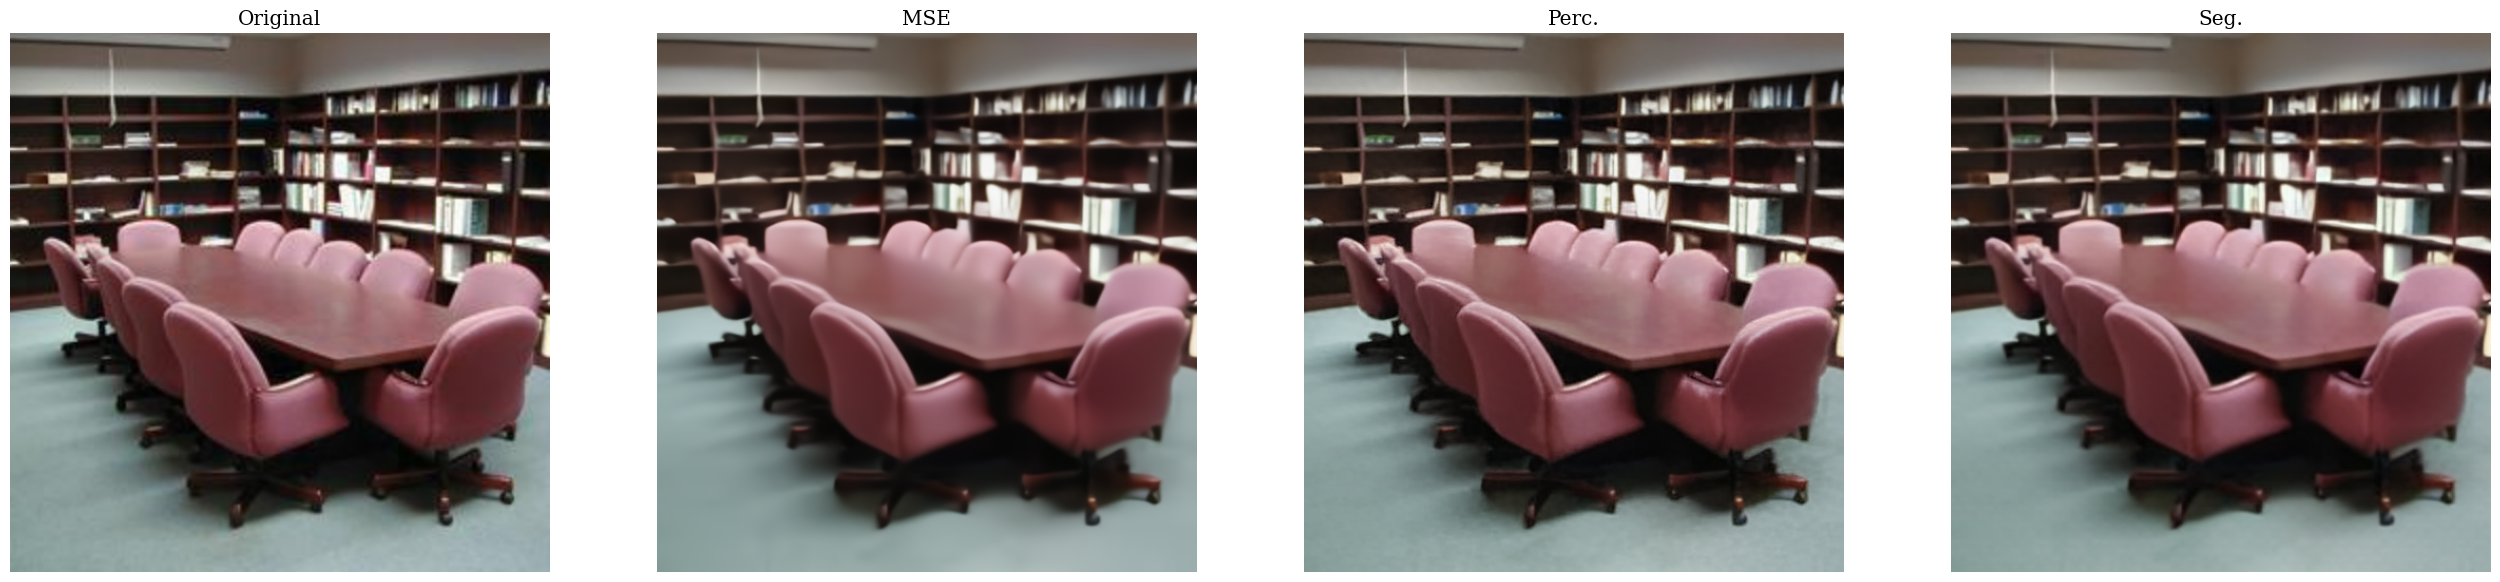

In [6]:
out_enc = net.compress(x, quality=1)
num_pixels = x.size(0) * x.size(2) * x.size(3)
real_bpp = sum(sum(len(ss) for ss in s) for s in out_enc["strings"]) * 8.0 / num_pixels

with torch.no_grad():
    out_net = net.forward(x, quality=1, q_task=8, task_idx=0)
out_net['x_hat'].clamp_(0, 1)
rec_img_mse = T.ToPILImage()(out_net['x_hat'].squeeze().cpu())
rec_img_mse_psnr = cal_psnr(x, out_net['x_hat'])

with torch.no_grad():
    out_net = net.forward(x, quality=1, q_task=1, task_idx=2)
out_net['x_hat'].clamp_(0, 1)
rec_img_perc = T.ToPILImage()(out_net['x_hat'].squeeze().cpu())
rec_img_perc_psnr = cal_psnr(x, out_net['x_hat'])

with torch.no_grad():
    out_net = net.forward(x, quality=1, q_task=8, task_idx=2)
out_net['x_hat'].clamp_(0, 1)
rec_img_seg = T.ToPILImage()(out_net['x_hat'].squeeze().cpu())
rec_img_seg_psnr = cal_psnr(x, out_net['x_hat'])

%matplotlib inline
# fix, axes = plt.subplots(1, 2, figsize=(32, 24))
fix, axes = plt.subplots(1, 4, figsize=(32, 24))
for ax in axes:
    ax.axis('off')

print(f'Bit-rate:  {real_bpp}bpp')
print(f'MSE PSNR:  {rec_img_mse_psnr}dB')
print(f'Perc PSNR: {rec_img_perc_psnr}dB')
print(f'Seg PSNR:  {rec_img_seg_psnr}dB')

axes[0].imshow(img)
axes[0].title.set_text('Original')

axes[1].imshow(rec_img_mse)
axes[1].title.set_text('MSE')

axes[2].imshow(rec_img_perc)
axes[2].title.set_text('Perc.')

axes[3].imshow(rec_img_seg)
axes[3].title.set_text('Seg.')

plt.show()

os.makedirs(f'./figures/ade20k/val{ade20k_val_idx}/', exist_ok=True)
img.save(f'./figures/ade20k/val{ade20k_val_idx}/val{ade20k_val_idx}_original.png')
rec_img_mse.save(f'./figures/ade20k/val{ade20k_val_idx}/val{ade20k_val_idx}_mse.png')
rec_img_perc.save(f'./figures/ade20k/val{ade20k_val_idx}/val{ade20k_val_idx}_perc.png')
rec_img_seg.save(f'./figures/ade20k/val{ade20k_val_idx}/val{ade20k_val_idx}_seg.png')


## Visualize Feature Map

In [ ]:
# define a hook to capture feature map
class FeatureMapHook:
    def __init__(self):
        self.feature_maps = []

    def __call__(self, module, input, output):
        self.feature_maps.append(output)


torch.Size([256, 256, 1])
torch.Size([128, 128, 1])
torch.Size([64, 64, 1])


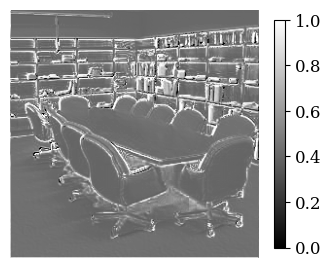

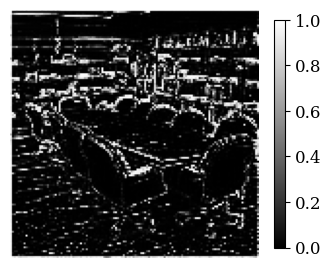

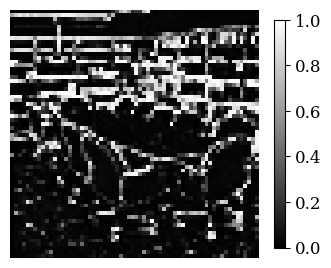

In [ ]:
target_layer_index = [1, 3, 5]

for i, stage in enumerate(target_layer_index):
    target_layer = eval(f'net.g_a{stage}.residual_group.score_predictor[0].out_conv[-1]')

    # create hook
    hook = FeatureMapHook()

    # register hook
    hook_handle = target_layer.register_forward_hook(hook)

    with torch.no_grad():
        net(x, quality=1, q_task=1, task_idx=0)
    print(hook.feature_maps[0][0].shape)
    predictor_enc = hook.feature_maps[0][0].sigmoid().squeeze(0).detach().cpu().numpy()

    # remove hook
    hook_handle.remove()

    %matplotlib inline
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.axis('off')

    im_predictor_enc = ax.imshow(predictor_enc, cmap='gray', vmin=0, vmax=1)
    # ax.title.set_text(f'Predictor in Encoder (Stage {3-i})')

    fig.colorbar(im_predictor_enc, ax=ax, shrink=0.74)
    fig.show()

    fig.savefig(f'./figures/ade20k/val{ade20k_val_idx}/val{ade20k_val_idx}_predictor_enc_g_a{stage}.pdf', bbox_inches='tight', pad_inches=0.0)


torch.Size([64, 64, 1])
torch.Size([128, 128, 1])
torch.Size([256, 256, 1])


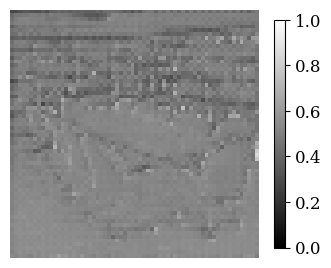

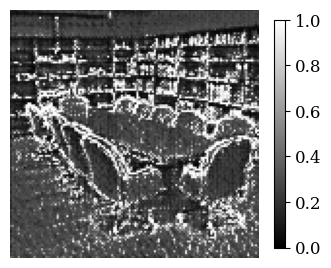

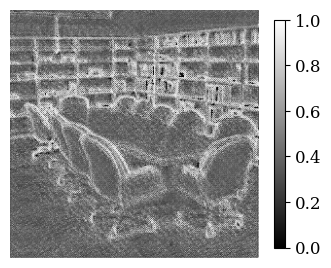

In [ ]:
target_layer_index = [2, 4, 6]

for i, stage in enumerate(target_layer_index):
    target_layer = eval(f'net.g_s{stage}.residual_group.score_predictor[0][0].out_conv[-1]')

    # create hook
    hook = FeatureMapHook()

    # register hook
    hook_handle = target_layer.register_forward_hook(hook)

    with torch.no_grad():
        net(x, quality=1, q_task=1, task_idx=0)
    print(hook.feature_maps[0][0].shape)
    predictor_mse = 1 - hook.feature_maps[0][0].sigmoid().squeeze(0).detach().cpu().numpy() # for better visualization

    # remove hook
    hook_handle.remove()

    %matplotlib inline
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.axis('off')

    im_predictor_mse = ax.imshow(predictor_mse, cmap='gray', vmin=0, vmax=1)
    # ax.title.set_text(f'Predictor in MSE Path (Stage {3-i})')

    fig.colorbar(im_predictor_mse, ax=ax, shrink=0.74)
    fig.show()

    fig.savefig(f'./figures/ade20k/val{ade20k_val_idx}/val{ade20k_val_idx}_predictor_mse_g_s{stage}.pdf', bbox_inches='tight', pad_inches=0.0)


torch.Size([64, 64, 1])
torch.Size([128, 128, 1])
torch.Size([256, 256, 1])


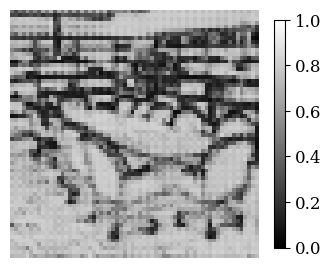

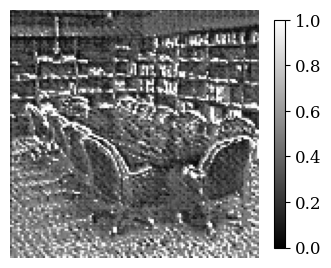

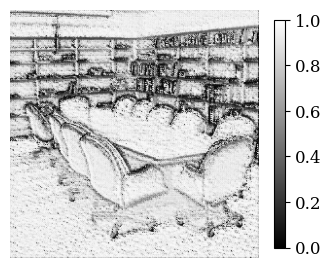

In [ ]:
target_layer_index = [2, 4, 6]

for i, stage in enumerate(target_layer_index):
    target_layer = eval(f'net.g_s{stage}.residual_group.score_predictor[2][0].out_conv[-1]')

    # create hook
    hook = FeatureMapHook()

    # register hook
    hook_handle = target_layer.register_forward_hook(hook)

    with torch.no_grad():
        net(x, quality=1, q_task=1, task_idx=2)
    print(hook.feature_maps[0][0].shape)
    predictor_seg = 1 - hook.feature_maps[0][0].sigmoid().squeeze(0).detach().cpu().numpy() # for better visualization

    # remove hook
    hook_handle.remove()

    %matplotlib inline
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.axis('off')

    im_predictor_seg = ax.imshow(predictor_seg, cmap='gray', vmin=0, vmax=1)
    # ax.title.set_text(f'Predictor in Seg. Path (Stage {3-i})')

    fig.colorbar(im_predictor_seg, ax=ax, shrink=0.74)
    fig.show()

    fig.savefig(f'./figures/ade20k/val{ade20k_val_idx}/val{ade20k_val_idx}_predictor_seg_g_s{stage}.pdf', bbox_inches='tight', pad_inches=0.0)


In [11]:
import cv2
from seg_util.util import colorize
import torch.nn.functional as F


value_scale = 255
mean = [0.485, 0.456, 0.406]
mean = [item * value_scale for item in mean]
std = [0.229, 0.224, 0.225]
std = [item * value_scale for item in std]
colors = np.loadtxt('./seg_data/ade20k/ade20k_colors.txt').astype('uint8')


def net_process(model, image, mean, std=None, flip=True):
    input = torch.from_numpy(image.transpose((2, 0, 1))).float()
    if std is None:
        for t, m in zip(input, mean):
            t.sub_(m)
    else:
        for t, m, s in zip(input, mean, std):
            t.sub_(m).div_(s)
    input = input.unsqueeze(0).cuda()
    if flip:
        input = torch.cat([input, input.flip(3)], 0)
    with torch.no_grad():
        output = model(input)
    _, _, h_i, w_i = input.shape
    _, _, h_o, w_o = output.shape
    if (h_o != h_i) or (w_o != w_i):
        output = F.interpolate(output, (h_i, w_i), mode='bilinear', align_corners=True)
    output = F.softmax(output, dim=1)
    if flip:
        output = (output[0] + output[1].flip(2)) / 2
    else:
        output = output[0]
    output = output.data.cpu().numpy()
    output = output.transpose(1, 2, 0)
    return output


def scale_process(model, image, classes, crop_h, crop_w, h, w, mean, std=None, stride_rate=2/3):
    ori_h, ori_w, _ = image.shape
    pad_h = max(crop_h - ori_h, 0)
    pad_w = max(crop_w - ori_w, 0)
    pad_h_half = int(pad_h / 2)
    pad_w_half = int(pad_w / 2)
    if pad_h > 0 or pad_w > 0:
        image = cv2.copyMakeBorder(image, pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half, cv2.BORDER_CONSTANT, value=mean)
    new_h, new_w, _ = image.shape
    stride_h = int(np.ceil(crop_h*stride_rate))
    stride_w = int(np.ceil(crop_w*stride_rate))
    grid_h = int(np.ceil(float(new_h-crop_h)/stride_h) + 1)
    grid_w = int(np.ceil(float(new_w-crop_w)/stride_w) + 1)
    prediction_crop = np.zeros((new_h, new_w, classes), dtype=float)
    count_crop = np.zeros((new_h, new_w), dtype=float)
    for index_h in range(0, grid_h):
        for index_w in range(0, grid_w):
            s_h = index_h * stride_h
            e_h = min(s_h + crop_h, new_h)
            s_h = e_h - crop_h
            s_w = index_w * stride_w
            e_w = min(s_w + crop_w, new_w)
            s_w = e_w - crop_w
            image_crop = image[s_h:e_h, s_w:e_w].copy()
            count_crop[s_h:e_h, s_w:e_w] += 1
            prediction_crop[s_h:e_h, s_w:e_w, :] += net_process(model, image_crop, mean, std)
    prediction_crop /= np.expand_dims(count_crop, 2)
    prediction_crop = prediction_crop[pad_h_half:pad_h_half+ori_h, pad_w_half:pad_w_half+ori_w]
    prediction = cv2.resize(prediction_crop, (w, h), interpolation=cv2.INTER_LINEAR)
    return prediction


def test(model, image_path, classes, mean, std, base_size, crop_h, crop_w, scales, colors):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # BGR 3 channel ndarray wiht shape H * W * 3
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert cv2 read image from BGR order to RGB order
    h, w, _ = image.shape
    prediction = np.zeros((h, w, classes), dtype=float)
    for scale in scales:
        long_size = round(scale * base_size)
        new_h = long_size
        new_w = long_size
        if h > w:
            new_w = round(long_size/float(h)*w)
        else:
            new_h = round(long_size/float(w)*h)
        image_scale = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        prediction += scale_process(model, image_scale, classes, crop_h, crop_w, h, w, mean, std)
    prediction = scale_process(model, image_scale, classes, crop_h, crop_w, h, w, mean, std)
    prediction = np.argmax(prediction, axis=2)
    gray = np.uint8(prediction)
    color = colorize(gray, colors)
    image_name = image_path.split('/')[-1].split('.')[0]
    gray_path = os.path.join(f'./figures/ade20k/val{ade20k_val_idx}/', image_name + '_gray.png')
    color_path = os.path.join(f'./figures/ade20k/val{ade20k_val_idx}/', image_name + '_color.png')
    cv2.imwrite(gray_path, gray)
    color.save(color_path)


In [ ]:
gt = cv2.imread(f'./notebooks/assets/ADE_val_{ade20k_val_idx}_gt.png', cv2.IMREAD_GRAYSCALE)
gt[gt == 0] = 255
gt = gt - 1
gt[gt == 254] = 255
gt_color = colorize(gt, colors)
gray_path = os.path.join(f'./figures/ade20k/val{ade20k_val_idx}/', f'val{ade20k_val_idx}_' + 'ground_truth_gray.png')
color_path = os.path.join(f'./figures/ade20k/val{ade20k_val_idx}/', f'val{ade20k_val_idx}_' + 'ground_truth_color.png')
cv2.imwrite(gray_path, gt)
gt_color.save(color_path)


test(model=seg_model.eval(),
     image_path=f'./notebooks/assets/ade20k_recon/val{ade20k_val_idx}_cls.png',
     classes=150,
     mean=mean,
     std=std,
     base_size=512,
     crop_h=513,
     crop_w=513,
     scales=[1.0],
     colors=colors)


test(model=seg_model.eval(),
     image_path=f'./notebooks/assets/ade20k_recon/val{ade20k_val_idx}_mse.png',
     classes=150,
     mean=mean,
     std=std,
     base_size=512,
     crop_h=513,
     crop_w=513,
     scales=[1.0],
     colors=colors)


test(model=seg_model.eval(),
     image_path=f'./notebooks/assets/ade20k_recon/val{ade20k_val_idx}_perc.png',
     classes=150,
     mean=mean,
     std=std,
     base_size=512,
     crop_h=513,
     crop_w=513,
     scales=[1.0],
     colors=colors)


test(model=seg_model.eval(),
     image_path=f'./notebooks/assets/ade20k_recon/val{ade20k_val_idx}_seg.png',
     classes=150,
     mean=mean,
     std=std,
     base_size=512,
     crop_h=513,
     crop_w=513,
     scales=[1.0],
     colors=colors)
